<a href="https://colab.research.google.com/github/AntonLissa/trajectory_prediction/blob/main/CV_2_trajectories_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd 'drive/MyDrive/CV_project'

Mounted at /content/drive/
/content/drive/MyDrive/CV_project


# Get the trajectory data from csv file and plot them

In [36]:
import pandas as pd

# Get trajectories from the csv file saved after the detection
df = pd.read_csv('trajectories/incrocio_1h_2fps.csv')

df['X'] = df['X'].apply(eval)  # convert string to list
df['Y'] = df['Y'].apply(eval)

# remap keys
nuove_chiavi = {vecchia_chiave: nuovo_numero for nuovo_numero, vecchia_chiave in enumerate(df['Key'], start=1)}

# rename keys
df['Key'] = df['Key'].map(nuove_chiavi)


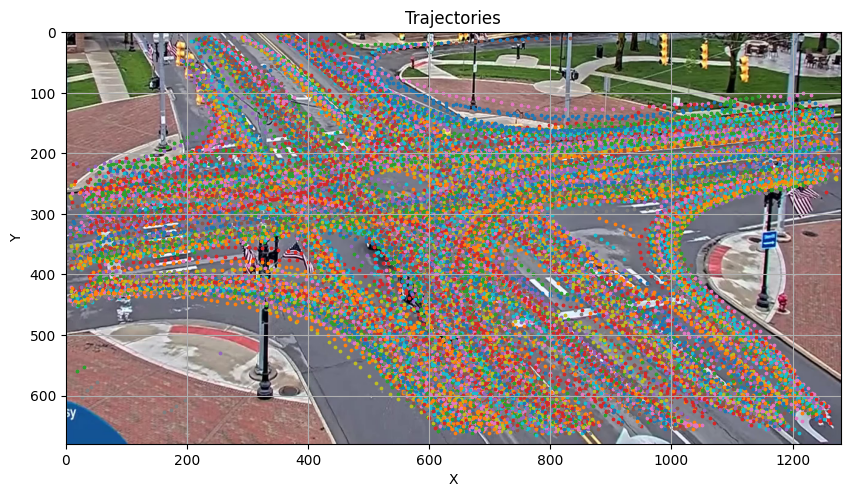

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np

def plot_df(df):
    cap = cv2.VideoCapture('videos/incrocio_mod.mp4') # draw a frame from the video
    ret, frame = cap.read()
    cap.release()
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    for i, row in df.iterrows():
        plt.scatter(row['X'], row['Y'], label=row['Key'], s=3)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Trajectories')
    plt.grid(True)

    plt.show()

plot_df(df)

# From here below there are various functions needed to study the data distribution and organization. This is needed to clean the valid trajectories from the noisy/useless ones

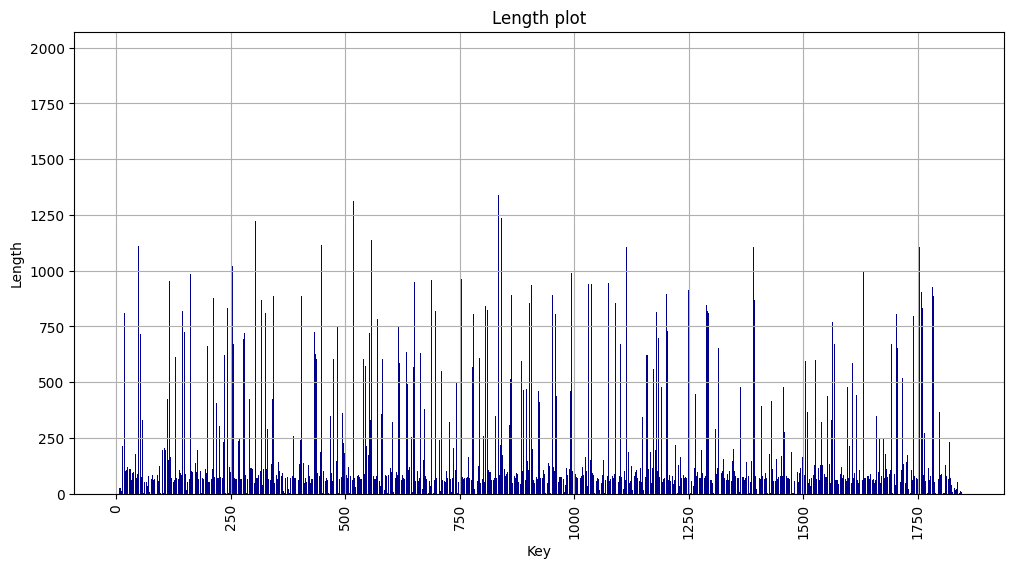

In [39]:
# hisogram
import matplotlib.pyplot as plt

def print_hist(df):
  # get the length
  df['lunghezza'] = df.apply(lambda row: len(row['X']), axis=1)
  # Make the histogram
  plt.figure(figsize=(12, 6))
  plt.bar(df['Key'], df['lunghezza'], color='darkblue')

  plt.xlabel('Key')
  plt.ylabel('Length')
  plt.title('Length plot')

  plt.xticks(rotation=90)
  plt.grid(True)
  plt.show()

print_hist(df)


231 trajectories found with length between 0 and 20


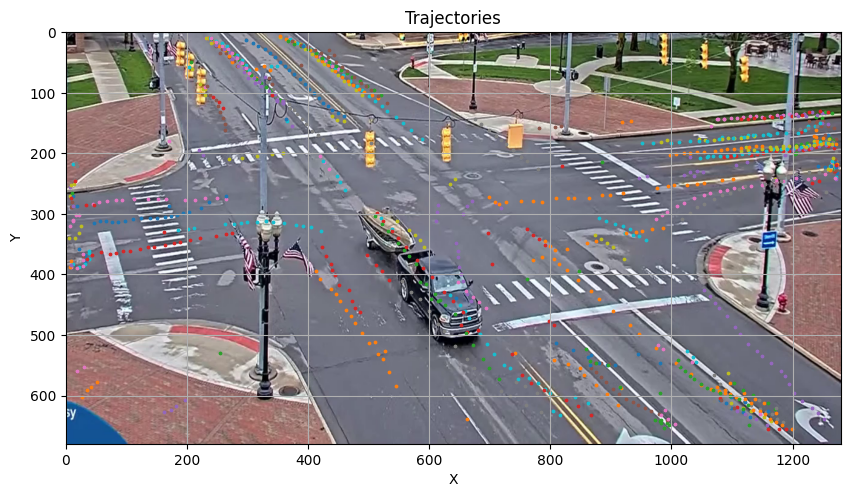

In [44]:
# get trajectories with length between min and max
# trajectories are valid if they have more then 23 points (from visual inspection)

import matplotlib.pyplot as plt
import cv2
def trajectory_lenght_filter(df, min, max):
    # filter the df
    traiettorie_filtrate = df[(df['lunghezza'] >= min) & (df['lunghezza'] <= max)]

    print(f"{len(traiettorie_filtrate)} trajectories found with length between {min} and {max}")

    return traiettorie_filtrate


min = 0
max = 20
traiettorie_filtrate = trajectory_lenght_filter(df, min, max)
plot_df(traiettorie_filtrate) # From this plot you can see that there are broken (invalid) trajectories

In [40]:
# Remove points that are too close with distance < soglia_distanza
# This is needed because when a car stopped at the beginning of the intersection the program continued to get its position
# Thus we have repeated static positions in the trajectories that are useless
import numpy as np

def rimuovi_punti_vicini(traiettorie, soglia_distanza):
    traiettorie_filtrate = []

    for index, row in traiettorie.iterrows():
        x_traiettoria = row['X']
        y_traiettoria = row['Y']

        x_filtrati = [x_traiettoria[0]]
        y_filtrati = [y_traiettoria[0]]

        for i in range(1, len(x_traiettoria)):
            distanza = np.sqrt((x_traiettoria[i] - x_filtrati[-1])**2 + (y_traiettoria[i] - y_filtrati[-1])**2)
            if distanza >= soglia_distanza:
                x_filtrati.append(x_traiettoria[i])
                y_filtrati.append(y_traiettoria[i])

        traiettorie_filtrate.append({'Key': row['Key'], 'X': x_filtrati, 'Y': y_filtrati})

    df_filtrato = pd.DataFrame(traiettorie_filtrate)

    return df_filtrato

df_filtrato = rimuovi_punti_vicini(df, soglia_distanza=10) # Let's use 10 pixel
df = df_filtrato

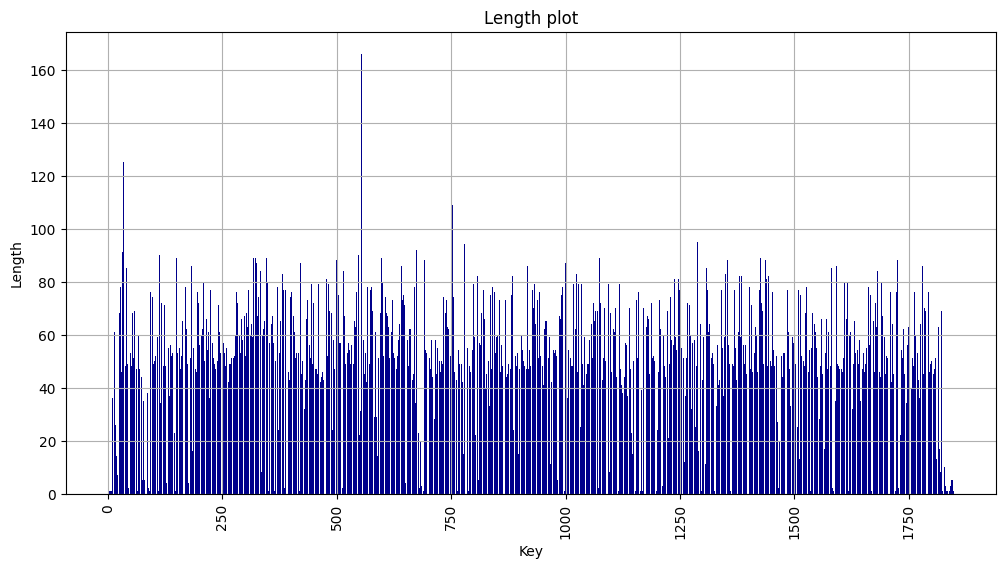

In [41]:
print_hist(df_filtrato)

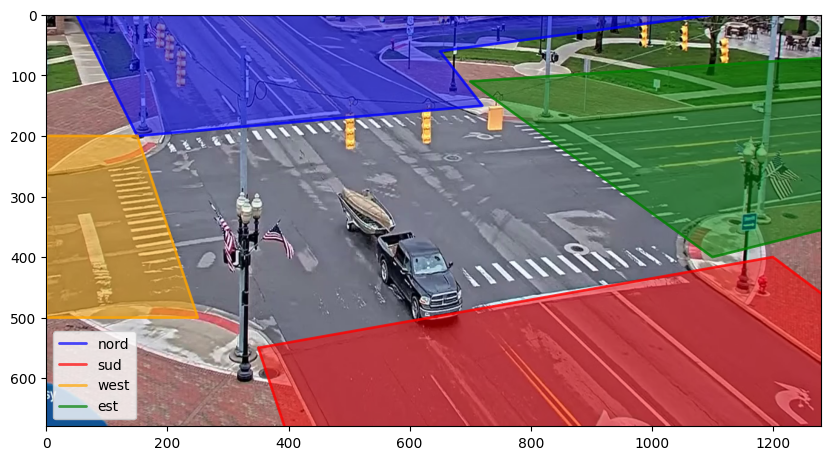

In [45]:
# Definition of N, S, W, E zones for cleaning the broken trajectories
# This is needed because we want to keep only the trajectories that start in a certain zone and end in a different zone
# This will allow to get rid of the broken trajectories problem

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

colors = {'nord': 'blue', 'est': 'green', 'sud':'red', 'west': 'orange'}


def plot_zone(name, zone):
    # get xy points coord
    x_coords, y_coords = zone.exterior.xy

    # plot the polygon
    plt.plot(x_coords, y_coords, alpha=0.7, linewidth=2, solid_capstyle='round', zorder=2, color=colors[name], label = name)
    plt.fill(x_coords, y_coords, alpha=0.5, zorder=1, color=colors[name])



# Zones definition
nord_zone = Polygon([Point(150, 200) , Point(720, 150), Point(650, 60), Point(1100, 0), Point(50, 0)])
sud_zone = Polygon([Point(350, 550) , Point(1200, 400), Point(1600, 700), Point(400, 700)])
west_zone = Polygon([Point(150, 200) , Point(250, 500), Point(0, 500), Point(0, 200)])
est_zone = Polygon([Point(1300, 70) , Point(700, 110), Point(1100, 400), Point(1300, 350)])

# Load a video frame
cap = cv2.VideoCapture('videos/incrocio_mod.mp4')
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(10, 8))
plot_zone('nord', nord_zone)
plot_zone('sud', sud_zone)
plot_zone('west', west_zone)
plot_zone('est', est_zone)
plt.legend()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))



In [46]:
# Get only valid trajectories: trajectories that start in a zone and end in a different zone

def inside_zones(zones, point):
  for zone in zones:
    if zone.contains(Point(point)):
       return zone
  return False

def get_valid_trajectories(df):
  indices = []
  for index, row in df.iterrows():

      start = (row['X'][0], row['Y'][0])
      end = (row['X'][-1], row['Y'][-1])

      start_zone = inside_zones([nord_zone, sud_zone, est_zone, west_zone], start)
      end_zone = inside_zones([nord_zone, sud_zone, est_zone, west_zone], end)
      if (start_zone!=False) and (end_zone!=False) and not(start_zone is end_zone):
          indices.append(row['Key'])
  return indices


indices = get_valid_trajectories(df)
print(len(indices), 'valid trajectories found')



1533 valid trajectories found


In [47]:
# Remove trajectories with key in a list of keys
def delete_by_keys(df, chiavi_da_rimuovere):
    df_filtrato = df[~df['Key'].isin(chiavi_da_rimuovere)]

    return df_filtrato


# Keep only trajectories with key in a list of keys
def keep_only_by_keys(df, keys_to_keep):
    df_filtered = df[df['Key'].isin(keys_to_keep)]
    df.drop(df.index.difference(df_filtered.index), inplace=True)
    df.reset_index(drop=True, inplace=True)

In [48]:
keep_only_by_keys(df, indices) # Keep only valid trajectories

48 trajectories found with length between 88 and 200


<Figure size 1400x1000 with 0 Axes>

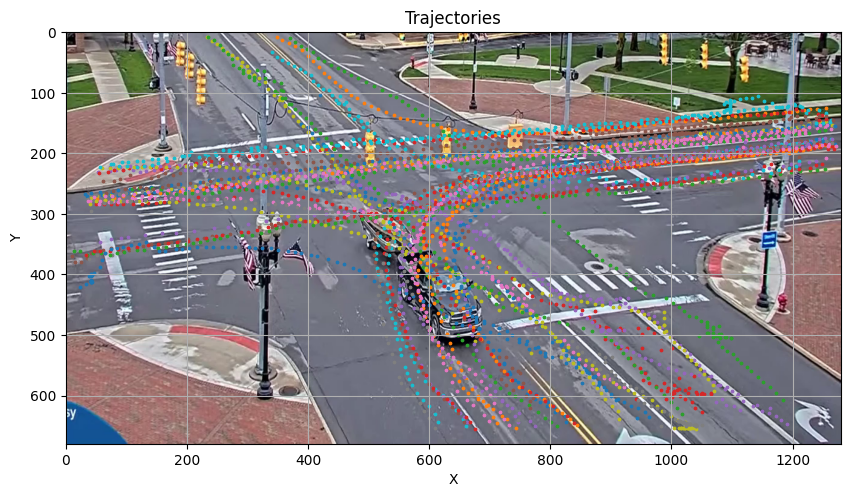

In [55]:
# Plot the valid trajectories with length between min and max
# From the plot below you can see that the trajectories with length > 87 are noisy
cap = cv2.VideoCapture('videos/incrocio_mod.mp4')
ret, frame = cap.read()
cap.release()

plt.figure(figsize=(14, 10))

traiettorie_filtrate = trajectory_lenght_filter(df, 88, 200)

plot_df(traiettorie_filtrate)



In [ ]:
# Save the cleaned trajectories
# Only trajectories with length between 0 and 87 are good, trajectories with more than 87 points are noisy

percorso_file_csv = "trajectories/trajectories_cleaned.csv"
traiettorie_filtrate = trajectory_lenght_filter(df, 0, 87) # keep only trajectories with length <= 87 (1485 trajectories)
keep_only_by_keys(df, traiettorie_filtrate['Key'])
df.to_csv(percorso_file_csv, index=False)


# Now we can do additional cleaning:
We need to:


1.   Make all the trajectories have the same length: the trajectories lengths go from 23 to 87, it's better to have them having all the same length for the outlier detection and for the LSTM training.
2.   Remove outliers
3.   Make other trajectories from known ones: it's better if we have a balanced dataset for the LSTM training





In [76]:
# read the csv with cleaned data

import pandas as pd
file_csv = "trajectories/trajectories_cleaned.csv"

df = pd.read_csv(file_csv)
df['X'] = df['X'].apply(eval)  #  convert string to list
df['Y'] = df['Y'].apply(eval)


In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import numpy as np


def plot_df(df, items_to_plot):
    cap = cv2.VideoCapture('videos/incrocio_mod.mp4') # video path
    ret, frame = cap.read()
    cap.release()
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) # show first frame of the video

    for i, row in df.iterrows():
        if i > items_to_plot: break
        plt.scatter(row['X'], row['Y'], label=row['Key'], s=3, color = 'blue')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Traiettorie')
    plt.grid(True)

    plt.show()


In [59]:
# the LSTM can only work with a fixed number of inputs and outputs
# there are trajectories way shorter than others, we would like to have a minimum size and get the trajectories shorter than this size to the desired length
# interpolation will do the job

from scipy.interpolate import splprep, splev

def interpolate_trajectories(df, n):
    interpolated_trajectories = []

    for index, row in df.iterrows():
        x = row['X']
        y = row['Y']
        key = row['Key']
        current_length = row['lunghezza']

        # if length < n then interpolate
        if current_length < n:

            tck, u = splprep([x, y], s=0.0)
            new_u = np.linspace(0, 1, n)
            new_x, new_y = splev(new_u, tck)
            length = len(new_x)

            interpolated_trajectories.append({'Key': key, 'X': new_x, 'Y': new_y, 'lunghezza':length})
        else:
            # else just add the trajectory
            interpolated_trajectories.append({'Key': key, 'X': x, 'Y': y, 'lunghezza': current_length})

    return pd.DataFrame(interpolated_trajectories)



In [61]:
# get the trajectory type, they are classified from the start zone and the end zone,
# this allows to better understand how the data is shaped


def inside_zones(zones, point):
  for zone in zones:
    if zone.contains(Point(point)):
       return zone

def get_start_zone(df, zones):
  ns = []
  ne = []
  nw = []
  sn = []
  se = []
  sw = []
  wn = []
  we = []
  ws = []
  en = []
  es = []
  ew = []


  for index, row in df.iterrows():
      start = (row['X'][0], row['Y'][0])
      end = (row['X'][-1], row['Y'][-1])

      start_zone = inside_zones(zones.values(), start)
      end_zone = inside_zones(zones.values(), end)

      north_zone = zones['N']
      south_zone = zones['S']
      east_zone = zones['E']
      west_zone = zones['W']

      if start_zone is north_zone:
        if end_zone is south_zone:
          ns.append(row['Key'])
        elif end_zone is east_zone:
          ne.append(row['Key'])
        elif end_zone is west_zone:
          nw.append(row['Key'])

      elif start_zone is south_zone:
        if end_zone is north_zone:
          sn.append(row['Key'])
        elif end_zone is west_zone:
          sw.append(row['Key'])
        elif end_zone is east_zone:
          se.append(row['Key'])

      elif start_zone is east_zone:
        if end_zone is south_zone:
          es.append(row['Key'])
        elif end_zone is north_zone:
          en.append(row['Key'])
        elif end_zone is west_zone:
          ew.append(row['Key'])

      elif start_zone is west_zone:
        if end_zone is south_zone:
          ws.append(row['Key'])
        elif end_zone is north_zone:
          wn.append(row['Key'])
        elif end_zone is east_zone:
          we.append(row['Key'])

  return {'N-S': ns, 'N-E':ne, 'N-W':nw, 'S-N':sn, 'S-E':se, 'S-W':sw, 'E-N':en, 'E-W':ew, 'E-S':es, 'W-N':wn, 'W-E':we, 'W-S':ws}




In [64]:
from sklearn.neighbors import LocalOutlierFactor
from scipy.interpolate import splprep, splev



def remove_outliers(df, n_points=90, n_neighbors=10): # df must be already interpolated


    # features calculation
    def calculate_features(df):
        features = []
        for index, row in df.iterrows():
            x = row['X']
            y = row['Y']
            feature_vector = np.concatenate([x, y])
            features.append(feature_vector)
        return np.array(features)

    # LOF for outliers
    def detect_outliers(features, n_neighbors):
        lof = LocalOutlierFactor(n_neighbors=n_neighbors)
        outlier_scores = lof.fit_predict(features)
        return outlier_scores


    features = calculate_features(df)
    outlier_scores = detect_outliers(features, n_neighbors)

    # Add result to df
    df['Outlier'] = outlier_scores

    # Remove outliers
    cleaned_df = df[df['Outlier'] != -1].copy()

    # Recalculate col lunghezza
    original_lengths = {row['Key']: row['lunghezza'] for _, row in df.iterrows()}
    cleaned_df['lunghezza'] = cleaned_df['Key'].apply(lambda key: original_lengths[key])

    cleaned_df['X'] = cleaned_df['X'].apply(list)
    cleaned_df['Y'] = cleaned_df['Y'].apply(list)

    #plot_df(cleaned_df, 1000)
    #plot_df(df, 1000)

    return cleaned_df[['Key', 'X', 'Y', 'lunghezza']]



In [65]:
def keep_only_by_keys(df, keys_to_keep):
    df_filtered = df[df['Key'].isin(keys_to_keep)]
    df_filtered.reset_index(drop=True, inplace=True)

    return df_filtered


In [67]:
# The amount of trajectories for each subzone (e.g. NS, NE, NW) are different, this may make the model biased
# It's better to have the same amount of data for each kind, this can be done by applying a random translation

import numpy as np

def generate_augmented_trajectories(df, n, max_translation=0.1):
    # take n random trajectories
    random_trajectories = df.sample(n=n, replace=True)
    modified_df = df.copy()

    for _, row in random_trajectories.iterrows():
        # make a random traslation
        translation_x = np.random.uniform(-max_translation, max_translation)
        translation_y = np.random.uniform(-max_translation, max_translation)

        # apply and save traslation
        modified_row = row.copy()
        modified_row['X'] = [x + translation_x for x in modified_row['X']]
        modified_row['Y'] = [y + translation_y for y in modified_row['Y']]

        modified_df = pd.concat([modified_df, pd.DataFrame([modified_row])], ignore_index=True)

    return modified_df



In [68]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon



def final_cleaning(df, zones, final_length, final_trajectory_number):

  full_ds = get_start_zone(df, zones) # return Key of the df

  for trajectory_group in full_ds.keys():
    full_ds[trajectory_group] = keep_only_by_keys(df, full_ds[trajectory_group])
    full_ds[trajectory_group] = full_ds[trajectory_group][0:100] # take first 100 elements
    full_ds[trajectory_group] = remove_outliers(interpolate_trajectories(full_ds[trajectory_group], final_length), final_length, 10) # reove outliers

    if full_ds[trajectory_group].shape[0] < final_trajectory_number:
      to_generate = final_trajectory_number - full_ds[trajectory_group].shape[0]
      full_ds[trajectory_group] = generate_augmented_trajectories(full_ds[trajectory_group], to_generate, 10) # generate n-length elements


    #print(trajectory_group, ':', full_ds[trajectory_group].shape[0])

    #print(trajectory_group, ':', full_ds[trajectory_group].shape[0])
  return full_ds




north_zone = Polygon([Point(150, 200) , Point(720, 150), Point(650, 60), Point(1100, 0), Point(50, 0)])
south_zone = Polygon([Point(350, 550) , Point(1200, 400), Point(1600, 700), Point(400, 700)])
west_zone = Polygon([Point(150, 200) , Point(250, 500), Point(0, 500), Point(0, 200)])
east_zone = Polygon([Point(1300, 70) , Point(700, 110), Point(1100, 400), Point(1300, 350)])



zones = {'N': north_zone, 'S':south_zone, 'E': east_zone, 'W': west_zone}


final_length = 90 # final length of all the trajectories
num = 200 # number of trajectories for each kind
seed = 42

final_dataframes = final_cleaning(df, zones, final_length, num)

north_df =  pd.concat([final_dataframes['N-S'], final_dataframes['N-W'], final_dataframes['N-E']]).sample(frac=1, random_state=seed).reset_index(drop=True)
south_df =  pd.concat([final_dataframes['S-N'], final_dataframes['S-W'], final_dataframes['S-E']]).sample(frac=1, random_state=seed).reset_index(drop=True)
east_df =  pd.concat([final_dataframes['E-S'], final_dataframes['E-W'], final_dataframes['E-N']]).sample(frac=1, random_state=seed).reset_index(drop=True)
west_df =  pd.concat([final_dataframes['W-S'], final_dataframes['W-N'], final_dataframes['W-E']]).sample(frac=1, random_state=seed).reset_index(drop=True)

total_df = pd.concat([north_df, south_df, east_df, west_df]).sample(frac=1, random_state=seed).reset_index(drop=True)
print(total_df.shape)


(2400, 4)


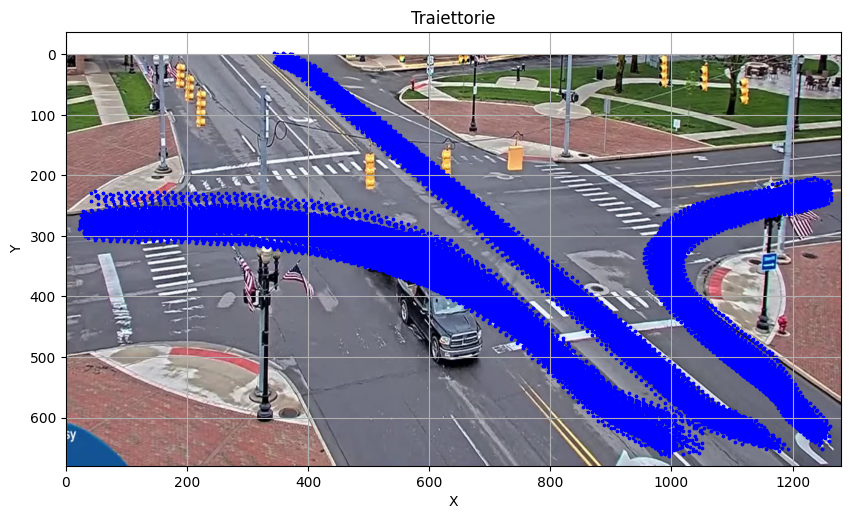

In [69]:
# Visualize what a dataset looks like after all the operations to see if data looks coherent
plot_df(south_df, 1500)

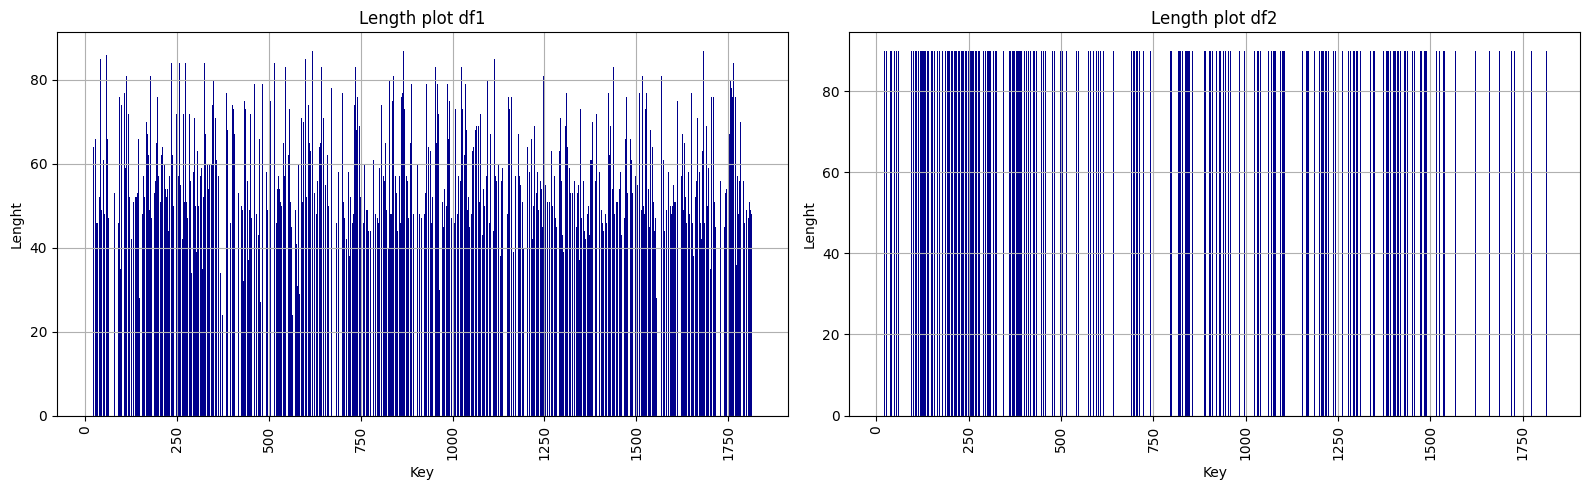

In [75]:
# visualize the lengths before and after interpolation
import matplotlib.pyplot as plt

def print_hist(df1, df2):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].bar(df1['Key'], df1['lunghezza'], color='darkblue')
    axs[0].set_xlabel('Key')
    axs[0].set_ylabel('Lenght')
    axs[0].set_title('Length plot df1')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].grid(True)

    axs[1].bar(df2['Key'], df2['lunghezza'], color='darkblue')
    axs[1].set_xlabel('Key')
    axs[1].set_ylabel('Lenght')
    axs[1].set_title('Length plot df2')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

print_hist(df, total_df)


In [73]:
# Save the dataframes
total_df.to_csv('Dataframes/total_df_200', index=False)
north_df.to_csv('Dataframes/north_df_200', index=False)
south_df.to_csv('Dataframes/south_df_200', index=False)
east_df.to_csv('Dataframes/east_df_200', index=False)
west_df.to_csv('Dataframes/west_df_200', index=False)